In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading the datasets seperately because spliting with indices
# only allows using one element to be selected 
ds_test, ds_test_info = tfds.load(
    'genomics_ood',
    split='test[:1000]',
    shuffle_files=True, # automatically shuffels the files
    as_supervised=True, # ds is turned into a tuple
    # if as_supervised=False: will be a dictionary with all the features
    with_info=True, # contains information about the builder
)

ds_train, ds_train_info = tfds.load(
    'genomics_ood',
    split='train[:100000]',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)



In [3]:
def transformFunction(seq, label):
    vocab = {"A":"1", "C":"2", "G":"3", "T":"0"}
    for key in vocab.keys():
        seq = tf.strings.regex_replace(seq, key, vocab[key])
    split = tf.strings.bytes_split(seq)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    seq = tf.one_hot(labels, 4)
    seq = tf.reshape(seq, (-1,))

    label = tf.one_hot(label, 10)
    return seq, label


In [4]:
buffer_train = ds_train_info.splits['train[:100000]'].num_examples 
buffer_test = ds_test_info.splits['test[:1000]'].num_examples 
# ds_train_info is the same as ds_test_info (they contain information about the complete dataset)

ds_train = ds_train.map(transformFunction)
ds_train = ds_train.cache() # caches the dataset → saving time (no opening of files etc.)
ds_train = ds_train.shuffle(buffer_size=buffer_train) # buffer size should be the size of the dataset
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
# alternatively: ds_train.prefetch(buffer_size) 
# buffer_size :=  the maximum number of elements that will be buffered when prefetching.  

# while model is executing training step s
# the pipeline is reading the data for the next step

# elements to prefetch should be equal to (or possibly greater than) 
# the number of batches consumed by a single training step


ds_test = ds_test.map(transformFunction)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(buffer_size=buffer_test)
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)



In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

model = tf.keras.Sequential(name="myModel")
model.add(tf.keras.Input(shape=(1000), name="Input"))
model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid, name="hidden_1"))
model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid, name="hidden_2"))
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name="otuput0"))

opt = tf.keras.optimizers.SGD(learning_rate=0.1, name='SGD')
loss_fn = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
model.summary()

Model: "myModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 256)               256256    
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               65792     
_________________________________________________________________
otuput0 (Dense)              (None, 10)                2570      
Total params: 324,618
Trainable params: 324,618
Non-trainable params: 0
_________________________________________________________________


### Run with GPU

In [6]:
history = model.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.6037 - accuracy: 0.3131 - val_loss: 1.4675 - val_accuracy: 0.3750
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.4874 - accuracy: 0.3544 - val_loss: 1.4918 - val_accuracy: 0.3430
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.4732 - accuracy: 0.3643 - val_loss: 1.4601 - val_accuracy: 0.3880
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.4651 - accuracy: 0.3693 - val_loss: 1.4593 - val_accuracy: 0.3870
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.4603 - accuracy: 0.3729 - val_loss: 1.4607 - val_accuracy: 0.3730
Epoch 6/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.4574 - accuracy: 0.3740 - val_loss: 1.4604 - val_accuracy: 0.3770
Epoch 7/10
3125/3125 [==============================] - 12s 4ms/step - loss: 1.4543 - accuracy: 0.3762 - val_loss: 1.4499 - val_ac

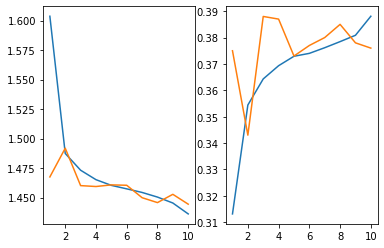

In [7]:
x_axis = np.arange(1, 11)


fig, ax = plt.subplots(1,2)
ax[0].plot(x_axis, history.history["loss"])
ax[0].plot(x_axis, history.history["val_loss"])
ax[1].plot(x_axis, history.history["accuracy"])
ax[1].plot(x_axis, history.history["val_accuracy"])
